In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Sequential
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data analysis

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   item      100000 non-null  object
 1   category  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB

First 5 rows of the dataset:
                            item  category
0  Impfuntersuchung Hund / Katze        19
1                   Cerenia 60mg        33
2         Impfbescheinigung (87)        19
3             Diagnosen: Impfung        13
4               Catalyst Chem 10        19

Statistical Summary:
            category
count  100000.000000
mean       24.463960
std         8.659614
min         0.000000
25%        19.000000
50%        19.000000
75%        33.000000
max        64.000000

Missing values per column:
item        0
category    0
dtype: int64

Value counts for the 'category' column:
category
19    50998
33    18864
30    12064
13     4358
12   

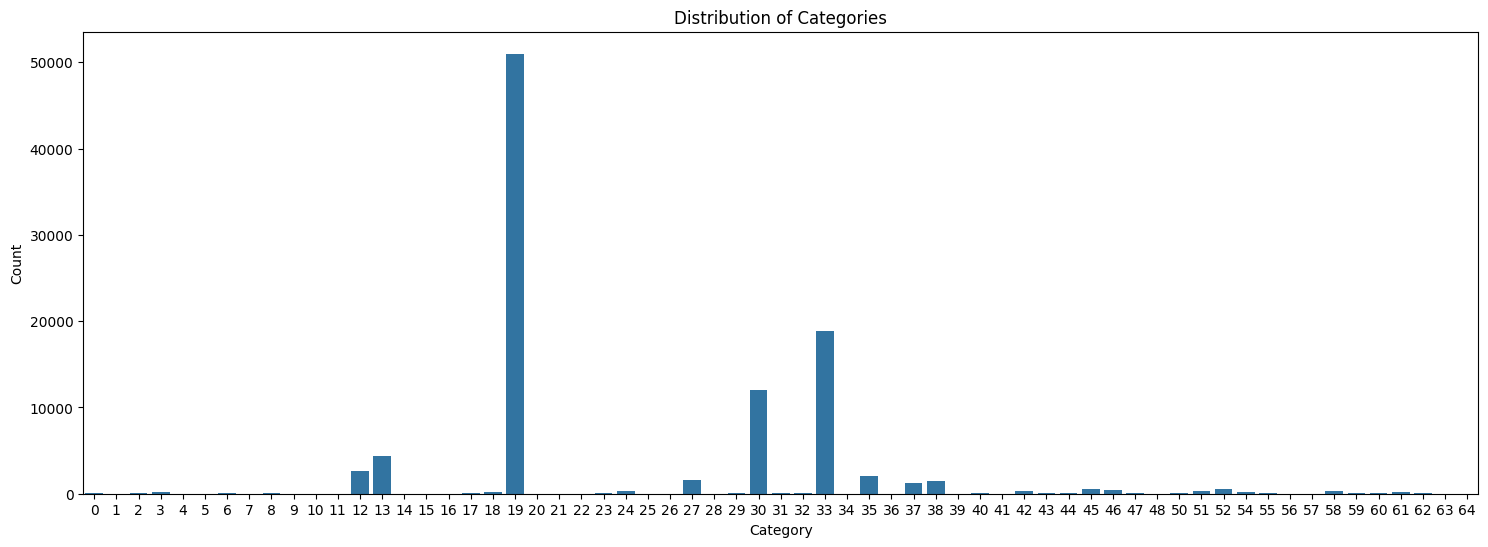


Average item length: 44.68701


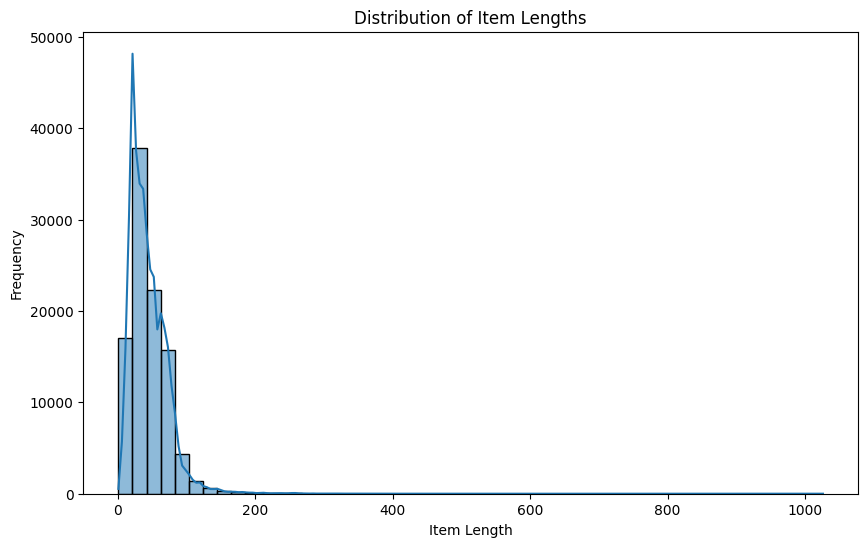

In [23]:
# Load and preprocess data
df = pd.read_csv('Datenset.csv', sep=';')
df.columns = ['item', 'category']
df.dropna(inplace=True) # Remove rows with missing values
# Display basic information about the DataFrame
print("Dataset Info:")
df.info()

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display basic statistical summary of numerical columns
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Get the value counts for the 'category' column
print("\nValue counts for the 'category' column:")
print(df['category'].value_counts())

# Plot the distribution of the 'category' column
plt.figure(figsize=(18, 6))
sns.countplot(data=df, x='category')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Calculate the average length of the item
df['item_length'] = df['item'].apply(len)
print("\nAverage item length:", df['item_length'].mean())

# Plot the distribution of item lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='item_length', bins=50, kde=True)
plt.title('Distribution of Item Lengths')
plt.xlabel('Item Length')
plt.ylabel('Frequency')
plt.show()

# Drop the temporary 'item_length' column
df = df.drop(columns=['item_length'])

# Data preprocessing

In [6]:
# Split Data
X = df['item']
y = df['category']

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Text Vectorization
vectorize_layer = TextVectorization(
    max_tokens=15000,
    output_mode='int',
    output_sequence_length=60)
vectorize_layer.adapt(X_train)

# Save the vocabulary
with open('vectorize_layer.pkl', 'wb') as f:
    pickle.dump({'config': vectorize_layer.get_config(),
                 'weights': vectorize_layer.get_weights()}, f)

# Modeling

In [9]:
# Build Model
num_classes = len(label_encoder.classes_)
model = Sequential([
    Input(shape=(1,), dtype=tf.string, name="input_layer"),
    vectorize_layer,
    Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        name="embedding_layer"),
    GlobalAveragePooling1D(name="pooling_layer"),
    Dense(64, activation='relu', name="dense_layer_1"),
    Dense(num_classes, activation='softmax', name="output_layer")
])

# Compile and Train
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting model training...")
history = model.fit(
    tf.constant(X_train.to_numpy(), dtype=tf.string), y_train_encoded,
    epochs=15,
    validation_data=(tf.constant(X_val.to_numpy(), dtype=tf.string), y_val_encoded),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)
print("Model training finished.")

# Save Model
model.save('/content/drive/MyDrive/invoice_model.keras')
print("Model saved to 'invoice_model.keras'")

# Generate predictions
y_pred_probs = model.predict(tf.constant(X_val.to_numpy(), dtype=tf.string))
y_pred = np.argmax(y_pred_probs, axis=1)

Starting model training...
Epoch 1/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.8225 - loss: 0.9489 - val_accuracy: 0.9378 - val_loss: 0.2243
Epoch 2/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9537 - loss: 0.1640 - val_accuracy: 0.9481 - val_loss: 0.1852
Epoch 3/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - accuracy: 0.9684 - loss: 0.1055 - val_accuracy: 0.9499 - val_loss: 0.1798
Epoch 4/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9736 - loss: 0.0805 - val_accuracy: 0.9510 - val_loss: 0.1824
Epoch 5/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - accuracy: 0.9752 - loss: 0.0687 - val_accuracy: 0.9507 - val_loss: 0.1894
Epoch 6/15
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9769 - loss: 0.0633 - val_accuracy: 0.9498 - val_loss: 0.1996
Model training finished.


OSError: [Errno 95] Operation not supported: '/content/drive/invoice_model.keras'

# Evaluation


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.00      0.00      0.00         3
           2       1.00      0.29      0.44         7
           3       0.93      0.87      0.90        31
           5       0.00      0.00      0.00         1
           6       1.00      0.86      0.92        21
           7       0.00      0.00      0.00         3
           8       0.86      0.92      0.89        13
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         2
          12       0.90      0.94      0.92       569
          13       1.00      1.00      1.00       866
          14       1.00      1.00      1.00         3
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         6
          18       0.79      0.84      0.82        32
          19       0.96      0.99      0.97     10106
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix saved to 'confusion_matrix.png'

Generating Precision-Recall Curve...
Precision-Recall curve saved to 'precision_recall_curve.png'


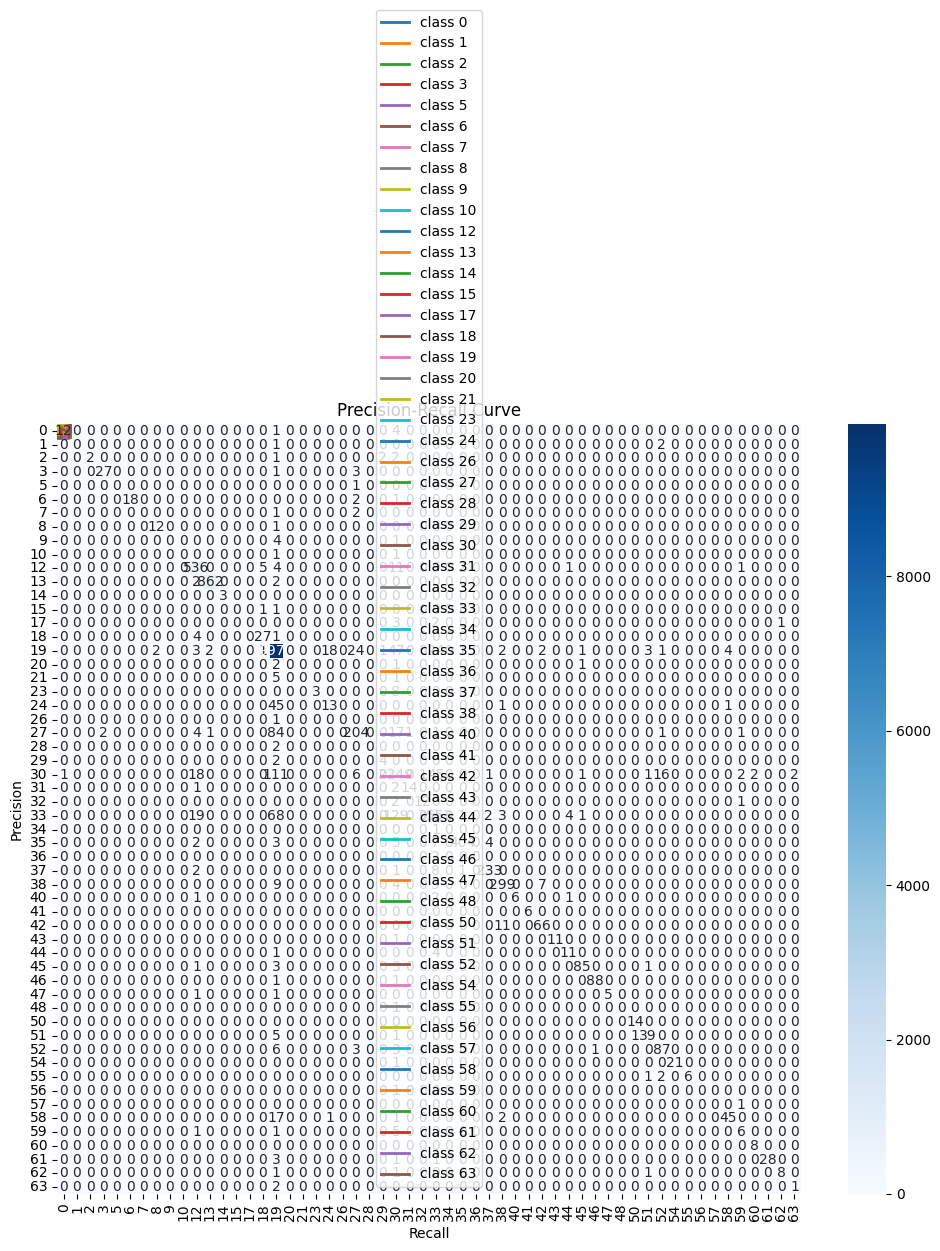

In [18]:
# Classification Report
print("\nClassification Report:")
target_names = [str(cls) for cls in label_encoder.classes_]
unique_labels_val = np.unique(y_val_encoded)
target_names_subset = [target_names[i] for i in unique_labels_val]

print(classification_report(y_val_encoded, y_pred, labels=unique_labels_val, target_names=target_names_subset))

# Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_val_encoded, y_pred, labels=unique_labels_val)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_subset, yticklabels=target_names_subset)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved to 'confusion_matrix.png'")

# Precision-Recall Curve
print("\nGenerating Precision-Recall Curve...")
y_val_bin = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))

# Ensure y_pred_probs has the correct shape for multiclass-multioutput
if y_pred_probs.shape[1] == 1: # Binary case, expand to 2 classes
    y_pred_probs = np.append(1 - y_pred_probs, y_pred_probs, axis=1)

precision = dict()
recall = dict()
# Iterate only over the unique labels present in the validation set
for i in unique_labels_val:
    # Find the index corresponding to the unique label in the binarized array
    class_index_in_binarized = np.where(np.arange(len(label_encoder.classes_)) == i)[0][0]
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, class_index_in_binarized], y_pred_probs[:, class_index_in_binarized])
    plt.plot(recall[i], precision[i], lw=2, label=f'class {target_names[i]}')


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.savefig('precision_recall_curve.png')
print("Precision-Recall curve saved to 'precision_recall_curve.png'")